In [30]:
try:
  from google.colab import files
  !pip install torch torchvision skorch hypertools
except:
  pass

In [31]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from datetime import datetime

from multiprocessing import cpu_count

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset, DataLoader

from torch.distributions import *

import skorch
import numpy as np
import hypertools as hyp

%load_ext tensorboard
%matplotlib inline
torch.autograd.set_detect_anomaly(True)
torch.set_num_threads=4

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Dataset

In [27]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(Subset(
    datasets.MNIST('/data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), indices=range(10000)),
    batch_size=64, shuffle=True, **kwargs)
test_loader = DataLoader(Subset(
    datasets.MNIST('/data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), indices=range(10000)),
    batch_size=1000, shuffle=True, **kwargs)

## Generic autoencoder class

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        now = datetime.now()
        current_time = now.strftime("%Y%m%d-%H%M%S")
        self.writer = SummaryWriter(log_dir="/data/runs/"+current_time)
        self.embeddings = []
        self.embedding_labels =[]
    
    def trains(self, device, train_loader, optimizer, epoch):
        self.train()
        loss_sum = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = self.compute_loss_train(data, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            self.writer.add_scalar('Loss/train', loss.item(), epoch*len(train_loader)+batch_idx)
            
    def tests(self, device, test_loader):
        self.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                loss, output = self.compute_loss_test(data, target)
                test_loss += loss
                l1 = F.l1_loss(output, data.view(-1, 784), reduction='sum')

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Reconstruction error: {}\n'.format(
            test_loss, l1))
        
    def add_embedding(self, loader):
        with torch.no_grad():
            labels = []
            embs = []
            for data, label in loader:
                labels.append(label)
                recon_batch, a, b = self(data)
                emb = self.reparameterize(a,b)
                embs.append(emb)
            print(type(tuple(embs)))
            self.embeddings.append(torch.cat(tuple(embs), dim=0).numpy())
            self.embedding_labels = torch.cat(tuple(labels), dim=0).numpy()
            
    def visualize_embeddings(self, epoch):
        hyp.plot(self.embeddings[epoch], '.', hue=self.embedding_labels, reduce='TSNE', ndims=2, save_path=f'/data/visualizations/{self.__class__.__name__}-{datetime.now().strftime("%Y%m%d-%H%M%S")}.svg')

## Autoencoder

In [92]:
class SimpleAutoencoder(Autoencoder):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output       
    
    def compute_loss_train(self, data, target):
        output = self(data)
        return F.nll_loss(output, target)
    
    def compute_loss_test(self, data, target):
        output = self(data)
        return F.nll_loss(output, target, reduction='sum').item(), output  # sum up batch loss

In [80]:
model = SimpleAutoencoder().to(device)
optimizer = optim.Adadelta(model.parameters())

# plot model
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# write to tensorboard
#writer.add_image('mnist_images', img_grid)

scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 14 + 1):
    model.trains(device, train_loader, optimizer, epoch)
    model.tests(device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/10000 (0%)]	Loss: 2.325908


KeyboardInterrupt: 

## Gaussian Variational Autoencoder

In [19]:
class VAE(Autoencoder):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(9216, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784))

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return torch.mean(BCE + KLD)
    
    def compute_loss_train(self, data, target):
        recon_batch, mu, logvar = self(data)
        return self.loss_function(recon_batch, data, mu, logvar)
    
    def compute_loss_test(self, data, target):
        recon_batch, mu, logvar = self(data)
        return self.loss_function(recon_batch, data, mu, logvar).item(), recon_batch  # sum up batch loss

In [21]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 10 + 1):
    vae.trains(device, train_loader, optimizer, epoch)
    vae.tests(device, test_loader)
    vae.add_embedding(test_loader)
    scheduler.step()

Train Epoch: 1 [0/10000 (0%)]	Loss: 10.542001
Train Epoch: 1 [640/10000 (6%)]	Loss: 3.665378
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.462005
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.021187
Train Epoch: 1 [2560/10000 (25%)]	Loss: -0.684038
Train Epoch: 1 [3200/10000 (32%)]	Loss: -1.051615
Train Epoch: 1 [3840/10000 (38%)]	Loss: -1.455510
Train Epoch: 1 [4480/10000 (45%)]	Loss: -1.925114
Train Epoch: 1 [5120/10000 (51%)]	Loss: -2.397856
Train Epoch: 1 [5760/10000 (57%)]	Loss: -2.942620
Train Epoch: 1 [6400/10000 (64%)]	Loss: -3.664965
Train Epoch: 1 [7040/10000 (70%)]	Loss: -4.159424
Train Epoch: 1 [7680/10000 (76%)]	Loss: -4.845878


KeyboardInterrupt: 

In [ ]:
vae.visualize_embeddings(-1)

## Stick-breaking process

In [22]:
def stickbreakingprocess(k, a, b):
    a = a + 100*torch.finfo(torch.float).eps
    b = b + 100*torch.finfo(torch.float).eps
    batch_size = a.size()[0]
    uniform_samples = Uniform(torch.tensor([0.0]), torch.tensor([1.0])).rsample(torch.tensor([batch_size,k])).view(-1,k)
    exp_a = 1/a 
    exp_b = 1/b
    km = (1- uniform_samples.pow(exp_b)).pow(exp_a)
    
    #no Nans are allowed in the matrix
    #assert not torch.isnan(km).any().item()
    
    sticks = []
    remaining_sticks = torch.ones_like(km[:,0])
    for i in range(0,k-1):
        sticks.append(remaining_sticks * km[:,i])
        remaining_sticks = remaining_sticks * (1-km[:,i])
    
    return torch.stack((*sticks, remaining_sticks), dim=1)

In [23]:
stickbreakingprocess(20, torch.rand(10,20), torch.rand(10,20)).sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

## Stick-breaking Autoencoder

In [24]:
class SBVAE(Autoencoder):
    def __init__(self, k):
        super(SBVAE, self).__init__()
        self.k = k
        
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(9216, 400)
        self.bn1 = nn.BatchNorm1d(num_features=k)
        self.bn1 = nn.BatchNorm1d(num_features=k)
        self.fc21 = nn.Linear(400, k)
        self.fc22 = nn.Linear(400, k)
        
        
        self.fc3 = nn.Linear(self.k, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(x))
        return F.softplus(self.bn1(self.fc21(h1))), F.softplus(self.bn1(self.fc22(h1)))

    def reparameterize(self, a, b):
        return stickbreakingprocess(self.k, a, b)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        a, b = self.encode(x)
        z = self.reparameterize(a, b)
        return self.decode(z), a, b
    
    def Beta(self, a,b):
        return torch.exp(torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a+b))
    
    def loss_function(self, recon_x, x, a, b, prior_alpha, prior_beta):
        #a = a + 100*torch.finfo(torch.float64).eps
        #b = b + 100*torch.finfo(torch.float64).eps
        BCE = F.binary_cross_entropy_with_logits(recon_x, x.view(-1, 784))
        kl = 1./(1+a*b) * self.Beta(1./a, b)
        kl += 1./(2+a*b) * self.Beta(2./a, b)
        kl += 1./(3+a*b) * self.Beta(3./a, b)
        kl += 1./(4+a*b) * self.Beta(4./a, b)
        kl += 1./(5+a*b) * self.Beta(5./a, b)
        kl += 1./(6+a*b) * self.Beta(6./a, b)
        kl += 1./(7+a*b) * self.Beta(7./a, b)
        kl += 1./(8+a*b) * self.Beta(8./a, b)
        kl += 1./(9+a*b) * self.Beta(9./a, b)
        kl += 1./(10+a*b) * self.Beta(10./a, b)
        kl *= (prior_beta-1)*b
                                                                                                                                            
        kl += (a-prior_alpha)/a * (-np.euler_gamma - torch.digamma(b) - 1/b) #T.psi(self.posterior_b)                                                                                        

        # add normalization constants                                                                                                                                                                
        kl += torch.log(a*b) + torch.log(self.Beta(prior_alpha, prior_beta))

        # final term                                                                                                                                                                                 
        kl += -(b-1)/b 
        
        return torch.mean(BCE + kl)
    
    def compute_loss_train(self, data, target):
        recon_batch, a, b = self(data)
        return self.loss_function(recon_batch, data, a, b, torch.Tensor([1]), torch.Tensor([5]))
    
    def compute_loss_test(self, data, target):
        recon_batch, a, b = self(data)
        return self.loss_function(recon_batch, data, a, b, torch.Tensor([1]), torch.Tensor([5])).item(), recon_batch  # sum up batch loss

In [28]:
sbvae = SBVAE(k=50).to(device)
optimizer = optim.Adam(sbvae.parameters(), lr=1e-3)
sbvae.writer.add_graph(sbvae, next(iter(train_loader))[0])


scheduler = StepLR(optimizer, step_size=1)
for epoch in range(1, 10 + 1): 
    sbvae.trains(device, train_loader, optimizer, epoch)
    sbvae.tests(device, test_loader)
    scheduler.step()
    sbvae.add_embedding(test_loader)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  """
/opt/conda/lib/python3.6/site-packages/torch/jit/__init__.py:1007: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[34, 510] (0.013803420588374138 vs. -0.1243

Train Epoch: 1 [0/10000 (0%)]	Loss: 4.494678
Train Epoch: 1 [640/10000 (6%)]	Loss: 3.772408
Train Epoch: 1 [1280/10000 (13%)]	Loss: 3.451346
Train Epoch: 1 [1920/10000 (19%)]	Loss: 3.113303
Train Epoch: 1 [2560/10000 (25%)]	Loss: 2.813490
Train Epoch: 1 [3200/10000 (32%)]	Loss: 2.395835
Train Epoch: 1 [3840/10000 (38%)]	Loss: 1.951618
Train Epoch: 1 [4480/10000 (45%)]	Loss: 1.752493
Train Epoch: 1 [5120/10000 (51%)]	Loss: 1.282803
Train Epoch: 1 [5760/10000 (57%)]	Loss: 0.861632
Train Epoch: 1 [6400/10000 (64%)]	Loss: 0.567494
Train Epoch: 1 [7040/10000 (70%)]	Loss: -0.364966
Train Epoch: 1 [7680/10000 (76%)]	Loss: -0.807840
Train Epoch: 1 [8320/10000 (83%)]	Loss: -1.707316
Train Epoch: 1 [8960/10000 (89%)]	Loss: -2.546937
Train Epoch: 1 [9600/10000 (96%)]	Loss: -3.233192

Test set: Average loss: -0.0042, Reconstruction error: 15128022.0

<class 'tuple'>
Train Epoch: 2 [0/10000 (0%)]	Loss: -4.024194
Train Epoch: 2 [640/10000 (6%)]	Loss: -4.152201
Train Epoch: 2 [1280/10000 (13%)]	Loss:

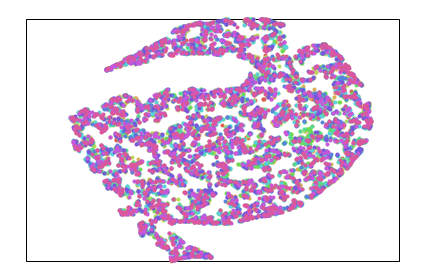

In [29]:
sbvae.visualize_embeddings(-1)